In [ ]:
#hide
from fastai.gen_doc.nbdoc import *
from utils import *
from fastai2.collab import *

# Building and training a model in PyTorch

## The basic training loop in PyTorch

In [ ]:
path = untar_data(URLs.ML_100k)
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=['user','movie','rating','timestamp'])

dls = CollabDataLoaders.from_df(ratings, item_name='movie', bs=64).cpu()
n_users,n_movies  = len(dls.classes['user']),len(dls.classes['movie'])
n_factors = 5

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
user_embedding  = (torch.randn(n_users,  n_factors) * 0.1).requires_grad_()
movie_embedding = (torch.randn(n_movies, n_factors) * 0.1).requires_grad_()
user_bias  = torch.zeros(n_users).requires_grad_()
movie_bias = torch.zeros(n_movies).requires_grad_()

In [ ]:
x,y = dls.one_batch()
x.shape,y.shape

(torch.Size([64, 2]), torch.Size([64, 1]))

In [ ]:
users,movies = x.T
users.shape,movies.shape

(torch.Size([64]), torch.Size([64]))

In [ ]:
usr_emb = user_embedding[users]
usr_b   = user_bias[users]
mov_emb = movie_embedding[movies]
mov_b   = movie_bias[movies]

In [ ]:
usr_emb.size()

torch.Size([64, 5])

In [ ]:
activation = (usr_emb * mov_emb).sum(dim=1) + usr_b + mov_b

In [ ]:
output = 5 * torch.sigmoid(activation)

In [ ]:
def model(x):
    users,movies = x.T
    usr_emb,usr_b = user_embedding[users],user_bias[users]
    mov_emb,mov_b = movie_embedding[movies],movie_bias[movies]
    activation = (usr_emb * mov_emb).sum(dim=1) + usr_b + mov_b
    return 5 * torch.sigmoid(activation)

In [ ]:
def mse_loss(output, target): return (output-target).pow(2).mean()

In [ ]:
loss = mse_loss(output,y)

In [ ]:
loss.backward()

In [ ]:
user_embedding.grad

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

In [ ]:
lr = 1e-2
user_embedding.data -= lr * user_embedding.grad

In [ ]:
def fit_one_epoch(model, dls, lr):
    for x,y in dls.train:
        output = model(x)
        loss = mse_loss(output,y)
        loss.backward()
        for param in [user_embedding, movie_embedding, user_bias, movie_bias]:
            param.data -= lr * param.grad
            param.grad.zero_()

In [ ]:
def validate(model, dls):
    n_elem,loss = 0,0.
    with torch.no_grad():
        for x,y in dls.valid:
            output = model(x)
            loss += mse_loss(output,y) * y.size(0)
            n_elem += y.size(0)
    return loss/n_elem

In [ ]:
validate(model, dls)

tensor(2.3391)

In [ ]:
def fit(model, dls, n_epoch, lr):
    for i in progress_bar(range(n_epoch)):
        fit_one_epoch(model, dls, lr)
        val_loss = validate(model, dls)
        print(f'Epoch {i+1}, validation loss: {val_loss:.6f}')

In [ ]:
fit(model, dls, 5, 3e-2)

Epoch 1, validation loss: 1.759184
Epoch 2, validation loss: 1.535529
Epoch 3, validation loss: 1.434513
Epoch 4, validation loss: 1.382121
Epoch 5, validation loss: 1.351903


### Refactoring the model with nn.Module

In [ ]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.user_bias = Embedding(n_users, 1)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.movie_bias = Embedding(n_movies, 1)
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        res = (users * movies).sum(dim=1, keepdim=True) 
        res += self.user_bias(x[:,0]) + self.movie_bias(x[:,1])
        return sigmoid_range(res, *self.y_range)

In [ ]:
model = DotProductBias(n_users, n_movies, n_factors)

In [ ]:
out = model(x)

In [ ]:
loss = F.mse_loss(out, y.float())

In [ ]:
loss_func = nn.MSELoss()
loss = loss_func(out, y.float())

In [ ]:
loss_func = MSELossFlat()
loss = loss_func(out, y)

In [ ]:
def fit_one_epoch(model, dls, lr):
    for x,y in dls.train:
        output = model(x)
        loss = loss_func(output,y)
        loss.backward()
        for param in model.parameters(): param.data -= lr * param.grad
        model.zero_grad()

### Going on the GPU

In [ ]:
out = out.cuda()
model = model.cuda()

In [ ]:
out = out.to(default_device())
model = model.to(default_device())

In [ ]:
default_device()

device(type='cuda', index=5)

In [ ]:
dls = CollabDataLoaders.from_df(ratings, item_name='movie', bs=64)

In [ ]:
fit_one_epoch(model, dls, 1e-3)

### Using torch.nn.optim

In [ ]:
import torch.optim as optim

In [ ]:
opt = optim.SGD(model.parameters(), lr=1e-3)

In [ ]:
def fit_one_epoch(model, opt, dls):
    for x,y in dls.train:
        output = model(x)
        loss = loss_func(output,y)
        loss.backward()
        opt.step()
        opt.zero_grad()

In [ ]:
loss_func = MSELossFlat(reduction='sum')

In [ ]:
def validate(model, dls):
    n_elem,loss = 0,0.
    with torch.no_grad():
        for x,y in dls.valid:
            output = model(x)
            loss += loss_func(output,y)
            n_elem += y.size(0)
    return loss/n_elem

In [ ]:
def fit(model, dls, n_epoch, lr, opt_func=optim.SGD):
    opt = opt_func(model.parameters(), lr=lr)
    for i in progress_bar(range(n_epoch)):
        fit_one_epoch(model, opt, dls)
        val_loss = validate(model, dls)
        print(f'Epoch {i+1}, validation loss: {val_loss:.6f}')

In [ ]:
model = DotProductBias(n_users, n_movies, n_factors).cuda()

In [ ]:
fit(model, dls, 4, 1e-3, opt_func=optim.Adam)

Epoch 1, validation loss: 1.034514
Epoch 2, validation loss: 0.909997
Epoch 3, validation loss: 0.883697
Epoch 4, validation loss: 0.869609


## Training a neural net

### Loading the data

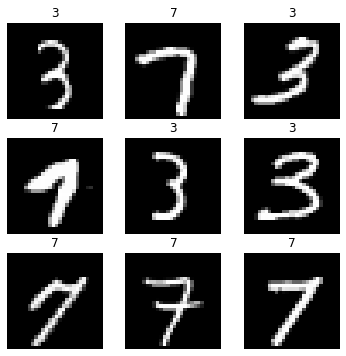

In [ ]:
from fastai.vision import *
path = untar_data(URLs.MNIST_SAMPLE)
dls = ImageDataLoaders.from_folder(path)
dls.show_batch(rows=3, figsize=(6,6))

In [ ]:
def fit_one_epoch(model, opt, dls, loss_func):
    for x,y in dls.train:
        output = model(x)
        loss = loss_func(output,y)
        loss.backward()
        opt.step()
        opt.zero_grad()
    
def validate(model, dls, loss_func):
    n_elem,loss,corrects = 0,0.,0.
    with torch.no_grad():
        for x,y in dls.valid:
            output = model(x)
            loss += loss_func(output, y, reduction='sum')
            corrects += (output.argmax(dim=1) == y).float().sum()
            n_elem += y.size(0)
    return loss/n_elem,corrects/n_elem

In [ ]:
def fit(model, dls, n_epoch, lr, loss_func, opt_func=optim.SGD):
    opt = opt_func(model.parameters(), lr=lr)
    for i in progress_bar(range(n_epoch)):
        fit_one_epoch(model, opt, dls, loss_func)
        val_loss, acc = validate(model, dls, loss_func)
        print(f'Epoch {i+1}, validation loss: {val_loss:.6f}, accuracy: {acc * 100:.2f}%')

In [ ]:
class FirstNeuralNet(Module):
    def __init__(self, n_in, n_hidden, n_out):
        self.linear1 = nn.Linear(n_in, n_hidden)
        self.linear2 = nn.Linear(n_hidden, n_out)
    
    def forward(self, x):
        x = x[:,0].view(x.size(0), -1)
        activation = F.relu(self.linear1(x))
        return self.linear2(activation)

In [ ]:
model = FirstNeuralNet(28*28, 1000, 2).cuda()
fit(model, dls, 2, 1e-3, F.cross_entropy, opt_func=optim.Adam)

Epoch 1, validation loss: 0.035692, accuracy: 98.82%
Epoch 2, validation loss: 0.020682, accuracy: 99.17%


### Cross entropy loss

In [ ]:
def log_softmax(x): return (x.exp()/(x.exp().sum(-1,keepdim=True))).log()

In [ ]:
x,y = dls.one_batch()
pred = model(x)
sm_pred = log_softmax(pred)

In [ ]:
sm_pred[0,0].item(), sm_pred[1,0].item(), sm_pred[2,1].item()

(-12.337810516357422, -3.4572341442108154, -0.00045327682164497674)

In [ ]:
sm_pred[[0,1,2], [0,0,1]]

tensor([-1.2338e+01, -3.4572e+00, -4.5328e-04], device='cuda:5', grad_fn=<IndexBackward>)

In [ ]:
def nll(input, target): return -input[range(target.shape[0]), target].mean()

In [ ]:
loss = nll(sm_pred, y)
loss

tensor(0.0014, device='cuda:5', grad_fn=<NegBackward>)

In [ ]:
def log_softmax(x): return x - x.exp().sum(-1,keepdim=True).log()

In [ ]:
def logsumexp(x):
    m = x.max(-1)[0]
    return m + (x-m[:,None]).exp().sum(-1).log()

In [ ]:
logsumexp(pred)[0], pred.logsumexp(-1)[0]

(tensor(5.9457, device='cuda:5', grad_fn=<SelectBackward>),
 tensor(5.9457, device='cuda:5', grad_fn=<SelectBackward>))

In [ ]:
def log_softmax(x): return x - x.logsumexp(-1,keepdim=True)

In [ ]:
F.nll_loss(F.log_softmax(pred, -1), y.cuda())

tensor(0.0014, device='cuda:5', grad_fn=<NllLossBackward>)

In [ ]:
F.cross_entropy(pred, y.cuda())

tensor(0.0014, device='cuda:5', grad_fn=<NllLossBackward>)

## Dropout and Batchnorm

### Dropout

In [ ]:
class DropoutLayer(Module):
    def __init__(self, p): self.p = p
    
    def forward(self, x):
        if self.training:
            mask = x.new(*x.size()).bernoulli_(1-self.p).div_(1-self.p)
            return mask * x

### Batch normalization

In [ ]:
class BatchNormLayer(Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        # NB: pytorch bn mom is opposite of what you'd expect!
        self.mom,self.eps = mom,eps
        self.mults = nn.Parameter(torch.ones (nf,))
        self.adds  = nn.Parameter(torch.zeros(nf,))
        self.register_buffer('vars',  torch.ones(1,nf))
        self.register_buffer('means', torch.zeros(1,nf))

    def update_stats(self, x):
        m = x.mean(0, keepdim=True)
        v = x.var (0, keepdim=True)
        self.means.lerp_(m, self.mom)
        self.vars.lerp_ (v, self.mom)
        return m,v
        
    def forward(self, x):
        if self.training:
            with torch.no_grad(): m,v = self.update_stats(x)
        else: m,v = self.means,self.vars
        x = (x-m) / (v+self.eps).sqrt()
        return x*self.mults + self.adds

In [ ]:
tst = BatchNormLayer(100)
tst.state_dict().keys()

odict_keys(['mults', 'adds', 'vars', 'means'])